In [6]:
import torch
import torch.nn.functional as F
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import Image
plt.rcParams['figure.dpi'] = 120

- references
    - https://blog.evjang.com/2016/08/variational-bayes.html
    - https://www.tuananhle.co.uk/notes/reverse-forward-kl.html

## basics

- $p$ vs. $q$
    - $p$ true data distribution，unknown
    - $q$ estimated distribution，to be optimized
- forward kl div：mean-seeking
    - $q = 0 \rightarrow p=0$

$$
\begin{align*} 
KL(P||Q) & = \sum_z p(z) \log \frac{p(z)}{q(z)} \\ 
& = \mathbb{E}_{p(z)}{\big[\log \frac{p(z)}{q(z)}\big]}\\ 
\end{align*}
$$

- reverse kl div: mode seeking
    - $p=0 \rightarrow q=0$ 

$$
\begin{align*} 
KL(Q||P) & = \sum_z q(z) \log \frac{q(z)}{p(z)} \\ 
& = \mathbb{E}_{p(z)}{\big[\log \frac{q(z)}{p(z)}\big]} 
\end{align*}
$$

In [11]:
Image(url='https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEhaSnD0TmegUI12OBQG7dborW0TsahuCz7koKV2tRzpe3DfQcHRTRtud-0xuzmdS9Oy8jHoXAw5nsow-sYduLXgM38TzPFSxiIMx7_aGGx3PH462MTV1KvaouMCFnonj4WFFXV9axdSRhQ/s1600/forward-KL.png', width=500)

In [12]:
Image(url='https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEgP80aN0IDF7ywcvN7-1XvndChYx7cVVaUPy4maD60TtBgtYEvh9TMX4qGqwXMEGoIZ68HeId60zx8HFWjzzrl9cG4aESJpW5wiYlfCqit1s_cKfp0qToMr2I76DSnTNA4h3mvn6mqZM7M/s1600/reverse-KL.png', width=500)

In [1]:
def optimize_loss(px, muq, sigmaq, kl_reverse=False):
    mu = torch.tensor([muq], requires_grad=True)
    sigma = torch.tensor([sigmaq], requires_grad=True)

    opt = torch.optim.Adam([mu, sigma])

    all_mu = []
    all_sigma = []
    loss_val = []
    all_qx = []

    for i in range(10000):

        Q = torch.distributions.Normal(mu, sigma)
        qx = Q.log_prob(x)

        if not kl_reverse:
            loss = F.kl_div(qx, px)
        else:
            # loss = F.kl_div(px.log(), qx.exp() + 1e-8)
            loss = F.kl_div(px.log(), qx, log_target=True)
            # samples = Q.rsample()
            # log_qx_samples = Q.log_prob(samples)
            # log_px_samples = torch.log(px)  # Assuming px is already in probability space
            # loss = torch.mean(log_qx_samples - log_px_samples)

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_val.append(loss.detach().numpy())
        all_mu.append(mu.data.numpy()[0])
        all_qx.append(qx.exp().detach().numpy())

        if i % 2000 == 0:
            print(i, loss_val[-1])

    plt.subplot(1, 2, 1)
    plt.plot(loss_val)
    plt.title('loss')

    plt.subplot(1, 2, 2)
    plt.plot(all_mu)
    plt.title('$\mu$')
    return mu.data.numpy()[0], sigma.data.numpy()[0], all_qx

In [3]:
mu1, sigma1 = -5, 1
mu2, sigma2 = 10, 1
gaussian1 = torch.distributions.Normal(mu1, sigma1)
gaussian2 = torch.distributions.Normal(mu2, sigma2)


x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,
                   mu1+mu2+5*sigma1+5*sigma2,
                   1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()


forward
0 2.081249


/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


2000 0.4642204
4000 0.27543005
6000 0.20085067
8000 0.16454785
2.4993849 5.231065


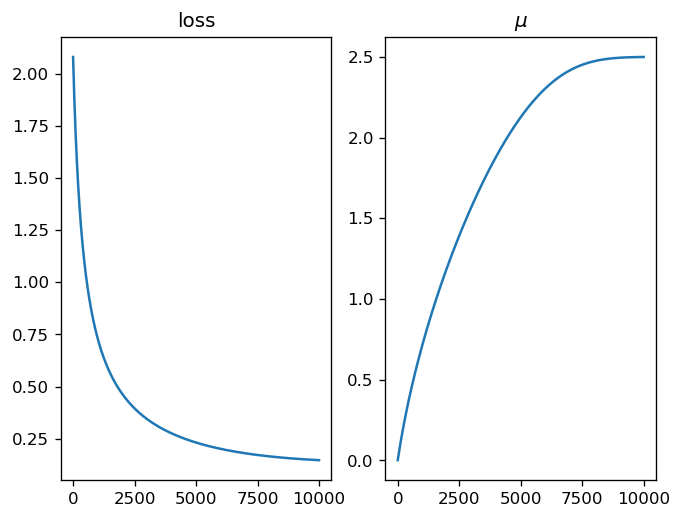

In [4]:
print('forward')
mu, sigma, all_qx = optimize_loss(px, 0., 1.)
print(mu, sigma)

backward
0 0.41518328
2000 0.1660943
4000 0.044496834
6000 0.00429745
8000 1.8608025e-05
-4.999959 0.9999993


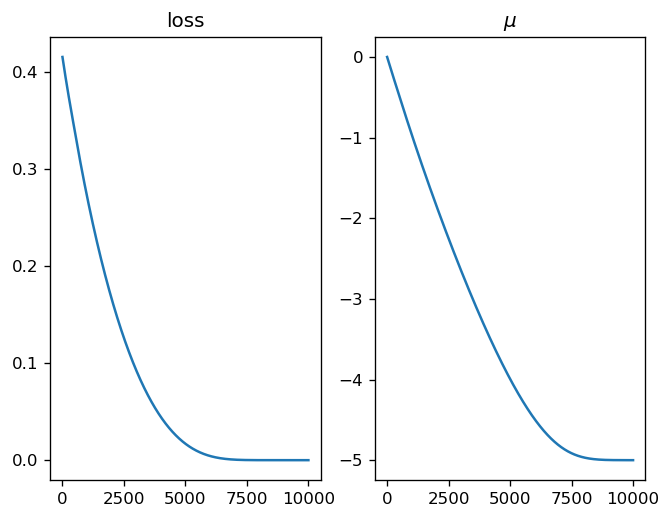

In [5]:
print('backward')
mu, sigma, all_qx = optimize_loss(px, 0., 1., kl_reverse=True)
print(mu, sigma)

## mode seeking vs. mean covering